# package imports...

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

# dataset CSV imports...

In [2]:
# I will be using the student_mat.csv dataset from the student performance
# dataset from the UCI machine learning repository. The dataset contains 
# academic performance data in addition to various other datapoints 
# which describe the socio-economic backgrounds of each respective student;

# the points in this csv are divided by semicolons instead of commas, therefore
# I must set the {delimiter} parameter to {';'} in order to correctly import the csv;

df_maths = pd.read_csv('student_mat.csv', delimiter = ';')

# functions...

In [3]:
# this function describes the unique datapoints found within each 
# categorical column, this will be essential for effective encoding
# of categorical data during the preprocessing phase;

def CATEGORICAL_DATAPOINTS(df,
                           C1 = 'school', 
                           C2 = 'sex', 
                           C3 = 'address', 
                           C4 = 'famsize', 
                           C5 = 'Pstatus', 
                           C6 = 'Mjob', 
                           C7 = 'Fjob', 
                           C8 = 'reason', 
                           C9 = 'guardian', 
                           C10 = 'schoolsup',
                           C11 = 'famsup',
                           C12 = 'paid',
                           C13 = 'activities',
                           C14 = 'nursery',
                           C15 = 'higher',
                           C16 = 'internet', 
                           C17 = 'romantic'):   

    dpoints = [C1, 
               C2, 
               C3, 
               C4, 
               C5, 
               C6, 
               C7, 
               C8, 
               C9, 
               C10,
               C11,
               C12,
               C13,
               C14,
               C15,
               C16, 
               C17]

    # the list is iterated through with a for loop...

    print(' the unique points contained within each categorical column are as follows... ')
    for i in dpoints:

        # ...and unique values are gathered and printed using pandas method {df[i].unique()} where
        # i == the current categorical column iteration;
        
        print()
        print(f'{i}')
        print(f'{df[f'{i}'].unique()}')
        print()

# this function generates a seaborn scatterplot, as I will be
# generating muultiple of these during the EDA phase, utilising
# a function ensures conciseness and readability of the code;

def SCATTERPLOT(x_, y_, hue_ = 'Final Grade',
                        col = 'bright', 
                        df = df_maths):

    """ a function to generate a scatterplot, in this
    case, parameter {hue} defaults to {'species'}, but 
    the function can be utilised to create a scatterplot
    with any combination of key data points """
    
    sns.scatterplot(x = x_,
                    y = y_,
                    hue = hue_, 
                    palette = col,
                    data = df)
    
    plt.legend(bbox_to_anchor = (1, 1), loc = 2)
    plt.show()

# this function generates a bar graph which will be used to display
# a hierarchy of feature importance determined by the regressive model 
# during the evaluation and results phase;

def DISPLAY_IMPORTANCE(model,
                       df_features, 
                       train_features, 
                       title, 
                       alignment, 
                       label):

    # I will be scaling data before training the regressive model, as such, 
    # this scaled data must be converted back to a pandas dataframe in order
    # for the results to be effectively displayed, this function first reconstructs
    # the dataframe from the given scaled numpy array;
    
    reconstructed_df = pd.DataFrame(train_features, columns = df_features.columns)
    
    # feature importances are then determined with attribute {.feature_importances_} 
    # and stored in the variable {important_features};
    
    important_features = model.feature_importances_
    
    # Important features are then sorted in descending order to 
    # increase graph readability; 
    
    indices = np.argsort(important_features)[::-1]
    
    # Only the features used by the model are plotted;
    
    plt.figure(figsize = (10, 6))
    plt.title(title)
    
    # The important features are then plotted;
    
    plt.barh(range(len(important_features)), important_features[indices], align = alignment)
    
    # The column names from the reconstructed pandas dataframe are then used
    # to label the graph;
    
    plt.yticks(range(len(important_features)), reconstructed_df.columns[indices])
    plt.xlabel(label)
    
    plt.show()

# a function to create a confusion matrix which will be used in the 
# evaluation / results phase for the classification model;

def CONFUSION_MATRIX(target, 
                     prediction,
                     label_x,
                     label_y,
                     colour = 'PuRd',
                     title = 'CONFUSION MATRIX'):

    # confusion matrix is instantiated to variable {matrix};
    
    matrix = confusion_matrix(target, prediction)
    
    plt.figure(figsize = (8, 8))

    # a seaborn heatmap is used to display the confusion matrix;
    
    sns.heatmap(matrix, 
                annot = True, 
                fmt = 'd', 
                cmap = colour, 
                xticklabels = 'T',
                yticklabels = 'P',)
    
    plt.title(title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()

# Data PreProcessing...

In [4]:
# view the first 5 rows of the dataset;

df_maths.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
# view the last 5 rows;

df_maths.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10
394,MS,M,19,U,LE3,T,1,1,other,at_home,...,3,2,3,3,3,5,5,8,9,9


In [6]:
# check for missing values;

missing = df_maths.isnull()

print(missing)

     school    sex    age  address  famsize  Pstatus   Medu   Fedu   Mjob  \
0     False  False  False    False    False    False  False  False  False   
1     False  False  False    False    False    False  False  False  False   
2     False  False  False    False    False    False  False  False  False   
3     False  False  False    False    False    False  False  False  False   
4     False  False  False    False    False    False  False  False  False   
..      ...    ...    ...      ...      ...      ...    ...    ...    ...   
390   False  False  False    False    False    False  False  False  False   
391   False  False  False    False    False    False  False  False  False   
392   False  False  False    False    False    False  False  False  False   
393   False  False  False    False    False    False  False  False  False   
394   False  False  False    False    False    False  False  False  False   

      Fjob  ...  famrel  freetime  goout   Dalc   Walc  health  absences  \

# Identifying Categorical Columns...

In [7]:
# display categorical columns using pandas {.select_dtypes()} method;

df_maths_cat = df_maths.select_dtypes(include = 'object')

print(df_maths_cat)

    school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activities nursery higher

# Identifying Categorical DataPoints...

In [8]:
# these categorical columns are then passed to the previously
# defined function {CATEGORICAL_DATAPOINTS()} to display the 
# unique datapoints within each column;

maths_catdpoints = CATEGORICAL_DATAPOINTS(df = df_maths)   

maths_catdpoints

 the unique points contained within each categorical column are as follows... 

school
['GP' 'MS']


sex
['F' 'M']


address
['U' 'R']


famsize
['GT3' 'LE3']


Pstatus
['A' 'T']


Mjob
['at_home' 'health' 'other' 'services' 'teacher']


Fjob
['teacher' 'other' 'services' 'health' 'at_home']


reason
['course' 'other' 'home' 'reputation']


guardian
['mother' 'father' 'other']


schoolsup
['yes' 'no']


famsup
['no' 'yes']


paid
['no' 'yes']


activities
['no' 'yes']


nursery
['yes' 'no']


higher
['yes' 'no']


internet
['no' 'yes']


romantic
['no' 'yes']



# Encoding Categorical Data...

In [9]:
# the {LabelEncoder()} is instantiated to the variable {encoder};

encoder = LabelEncoder()

# and ordinal categorical columns are encoded;

df_maths['Mjob'] = encoder.fit_transform(df_maths['Mjob'])
df_maths['Fjob'] = encoder.fit_transform(df_maths['Fjob'])
df_maths['reason'] = encoder.fit_transform(df_maths['reason'])
df_maths['guardian'] = encoder.fit_transform(df_maths['guardian'])

In [10]:
print(df_maths)

    school sex  age address famsize Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0       GP   F   18       U     GT3       A     4     4     0     4  ...   
1       GP   F   17       U     GT3       T     1     1     0     2  ...   
2       GP   F   15       U     LE3       T     1     1     0     2  ...   
3       GP   F   15       U     GT3       T     4     2     1     3  ...   
4       GP   F   16       U     GT3       T     3     3     2     2  ...   
..     ...  ..  ...     ...     ...     ...   ...   ...   ...   ...  ...   
390     MS   M   20       U     LE3       A     2     2     3     3  ...   
391     MS   M   17       U     LE3       T     3     1     3     3  ...   
392     MS   M   21       R     GT3       T     1     1     2     2  ...   
393     MS   M   18       R     LE3       T     3     2     3     2  ...   
394     MS   M   19       U     LE3       T     1     1     2     0  ...   

     famrel  freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0         4     

In [11]:
# nominal columns are then encoded using pandas {.get_dummies()} method;

df_maths = pd.get_dummies(df_maths, 
                          columns = ['school', 
                          'sex',
                          'address',
                          'famsize',
                          'Pstatus',
                          'schoolsup',
                          'famsup',
                          'paid',
                          'activities',
                          'nursery',
                          'higher',
                          'internet',
                          'romantic'],
                          drop_first = True)

# the {drop_first} parameter removes the inverse of each encoded column, as
# it is already implied and can cause issues with noise within the 
# training of ML models.

In [12]:
print(df_maths)

     age  Medu  Fedu  Mjob  Fjob  reason  guardian  traveltime  studytime  \
0     18     4     4     0     4       0         1           2          2   
1     17     1     1     0     2       0         0           1          2   
2     15     1     1     0     2       2         1           1          2   
3     15     4     2     1     3       1         1           1          3   
4     16     3     3     2     2       1         0           1          2   
..   ...   ...   ...   ...   ...     ...       ...         ...        ...   
390   20     2     2     3     3       0         2           1          2   
391   17     3     1     3     3       0         1           2          1   
392   21     1     1     2     2       0         2           1          1   
393   18     3     2     3     2       0         1           3          1   
394   19     1     1     2     0       0         0           1          1   

     failures  ...  famsize_LE3  Pstatus_T  schoolsup_yes  famsup_yes  \
0 

# Renaming Columns for Clarity...

In [13]:
# each column is then renamed to promote readability and interpretability
# of results;

df_maths = df_maths.rename(columns = {'Pstatus_T': 'Parental Cohabitation',
                                      'famsize_LE3': 'Small Family',
                                      'schoolsup_yes': 'School Support',
                                      'famsup_yes': 'Familial Support',
                                      'reason': 'Reason School',
                                      'guardian': 'Guardian',
                                      'paid_yes': 'Extra Tutoring',
                                      'activities_yes': 'Extra Curricular',
                                      'nursery_yes': 'Nursery',
                                      'failures': 'Past Failures',
                                      'studytime': 'Study Time',
                                      'traveltime': 'Travel Time',
                                      'higher_yes': 'Higher Ed',
                                      'internet_yes': 'Home WiFi',
                                      'romantic_yes': 'In Relationship',
                                      'famrel': 'Family Closeness',
                                      'freetime': 'Free Time',
                                      'goout': 'Social Life',
                                      'Dalc': 'Workday Alc',
                                      'Walc': 'Weekend Alc',
                                      'health': 'Health',
                                      'absences': 'Absent',
                                      'G1': 'First Grade',
                                      'G2': 'Second Grade',
                                      'G3': 'Final Grade',
                                      'school_MS': 'School MS',
                                      'sex_M': 'Male',
                                      'age': 'Age',
                                      'address_U': 'Urban Address',
                                      'Fedu': "Father's Ed",
                                      'Medu': "Mother's Ed",
                                      'Mjob': "Mother's Job",
                                      'Fjob': "Father's Job"})

In [14]:
# the dataset is now fully cleaned and encoded and ready for machine learning models;

df_maths

,Age,Mother's Ed,Father's Ed,Mother's Job,Father's Job,Reason School,Guardian,Travel Time,Study Time,Past Failures,...,Small Family,Parental Cohabitation,School Support,Familial Support,Extra Tutoring,Extra Curricular,Nursery,Higher Ed,Home WiFi,In Relationship
0,18,4,4,0,4,0,1,2,2,0,...,False,False,True,False,False,False,True,True,False,False
1,17,1,1,0,2,0,0,1,2,0,...,False,True,False,True,False,False,False,True,True,False
2,15,1,1,0,2,2,1,1,2,3,...,True,True,True,False,True,False,True,True,True,False
3,15,4,2,1,3,1,1,1,3,0,...,False,True,False,True,True,True,True,True,True,True
4,16,3,3,2,2,1,0,1,2,0,...,False,True,False,True,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,3,3,0,2,1,2,2,...,True,False,False,True,True,False,True,True,False,False
391,17,3,1,3,3,0,1,2,1,0,...,True,True,False,False,False,False,False,True,True,False
392,21,1,1,2,2,0,2,1,1,3,...,False,True,False,False,False,False,False,True,False,False
393,18,3,2,3,2,0,1,3,1,0,...,True,True,False,False,False,False,False,True,True,False


# Exploratory Data Analysis

In [15]:
# I will perform a brief EDA to get some shallow insight on the dataset
# which will inform the questions I need to ask and the model selection process;

df_maths.info

<bound method DataFrame.info of      Age  Mother's Ed  Father's Ed  Mother's Job  Father's Job  Reason School  \
0     18            4            4             0             4              0   
1     17            1            1             0             2              0   
2     15            1            1             0             2              2   
3     15            4            2             1             3              1   
4     16            3            3             2             2              1   
..   ...          ...          ...           ...           ...            ...   
390   20            2            2             3             3              0   
391   17            3            1             3             3              0   
392   21            1            1             2             2              0   
393   18            3            2             3             2              0   
394   19            1            1             2             0              0

In [16]:
# quickly check the size of the dataset;

df_maths.shape

(395, 33)

In [17]:
# check various key statistical truths of the dataset;

df_maths.describe()

,Age,Mother's Ed,Father's Ed,Mother's Job,Father's Job,Reason School,Guardian,Travel Time,Study Time,Past Failures,Family Closeness,Free Time,Social Life,Workday Alc,Weekend Alc,Health,Absent,First Grade,Second Grade,Final Grade
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,2.169620,2.281013,1.255696,0.853165,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,1.227473,0.863542,1.208236,0.536684,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,3.000000,3.000000,3.000000,1.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [18]:
# check for unique values;

df_maths.nunique()

Age                       8
Mother's Ed               5
Father's Ed               5
Mother's Job              5
Father's Job              5
Reason School             4
Guardian                  3
Travel Time               4
Study Time                4
Past Failures             4
Family Closeness          5
Free Time                 5
Social Life               5
Workday Alc               5
Weekend Alc               5
Health                    5
Absent                   34
First Grade              17
Second Grade             17
Final Grade              18
School MS                 2
Male                      2
Urban Address             2
Small Family              2
Parental Cohabitation     2
School Support            2
Familial Support          2
Extra Tutoring            2
Extra Curricular          2
Nursery                   2
Higher Ed                 2
Home WiFi                 2
In Relationship           2
dtype: int64

In [19]:
# create a correlation matrix for the dataset, I want to see
# which variables correlate to the final grade of each student;

df_maths_corrmatrix = df_maths.corr(numeric_only = True)

print(df_maths_corrmatrix)

                            Age  Mother's Ed  Father's Ed  Mother's Job  \
Age                    1.000000    -0.163658    -0.163438     -0.069104   
Mother's Ed           -0.163658     1.000000     0.623455      0.454805   
Father's Ed           -0.163438     0.623455     1.000000      0.243327   
Mother's Job          -0.069104     0.454805     0.243327      1.000000   
Father's Job          -0.035191     0.157920     0.200169      0.196758   
Reason School         -0.015337     0.117653     0.043099      0.022022   
Guardian               0.290485    -0.023918    -0.133644      0.014787   
Travel Time            0.070641    -0.171639    -0.158194     -0.109752   
Study Time            -0.004140     0.064944    -0.009175     -0.023097   
Past Failures          0.243665    -0.236680    -0.250408     -0.073377   
Family Closeness       0.053940    -0.003914    -0.001370      0.038584   
Free Time              0.016434     0.030891    -0.012846      0.114321   
Social Life            0.

# Visualisations...

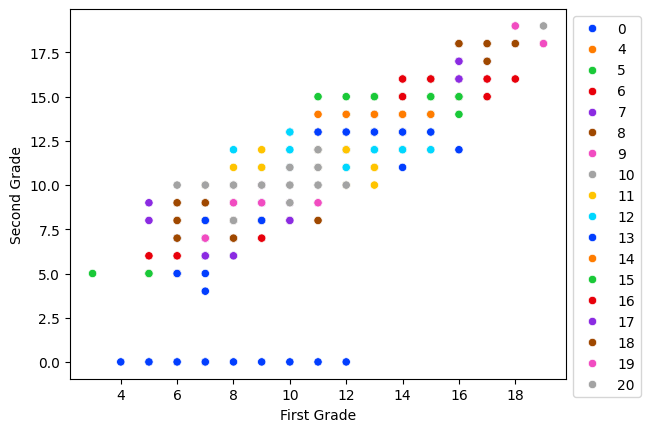

In [20]:
# a scatterplot to map the final result of each student depending on their first
# two results;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Second Grade', hue_ = 'Final Grade', df = df_maths)

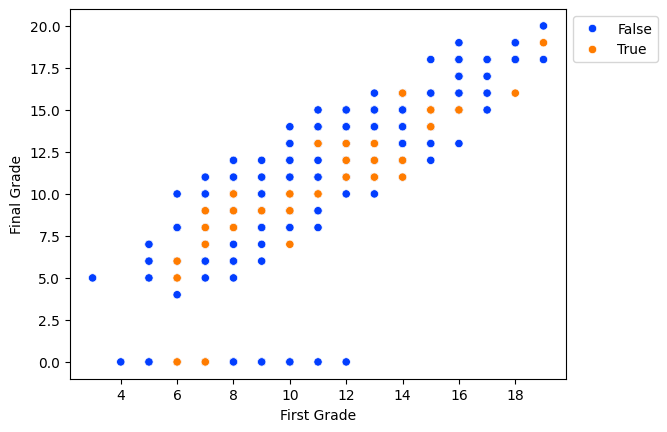

In [21]:
# a scatterplot to display differences in academic performance across both schools;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Final Grade', hue_ = 'School MS', df = df_maths)

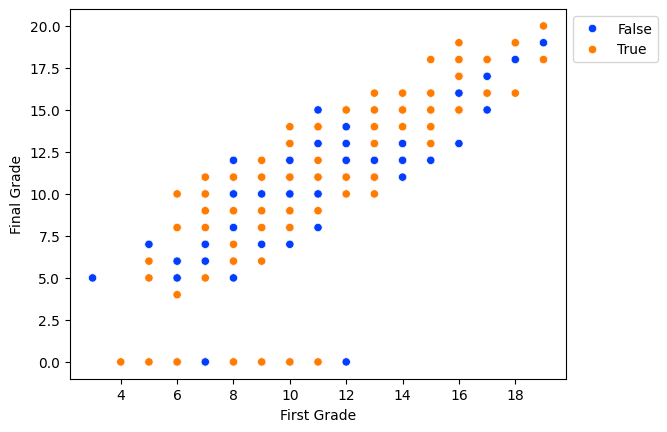

In [22]:
# a scatterplot to display academic performance levels in accordance to 
# whether the student has an Urban or Rural address;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Final Grade', hue_ = 'Urban Address', df = df_maths)

## scatterplots which display academic performance based on a given student's parent's occupation and education;

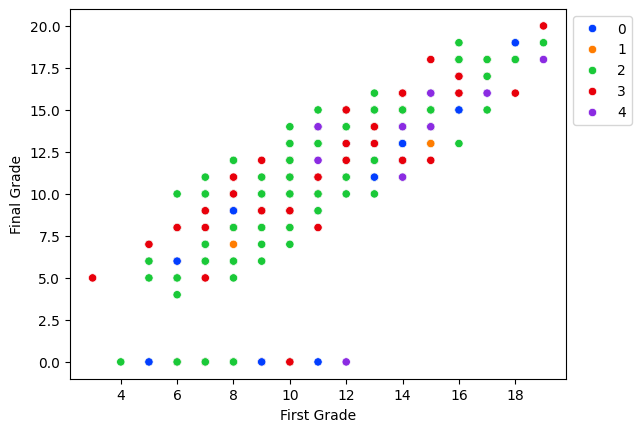

In [23]:
# fathers job;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Final Grade', hue_ = "Father's Job", df = df_maths)

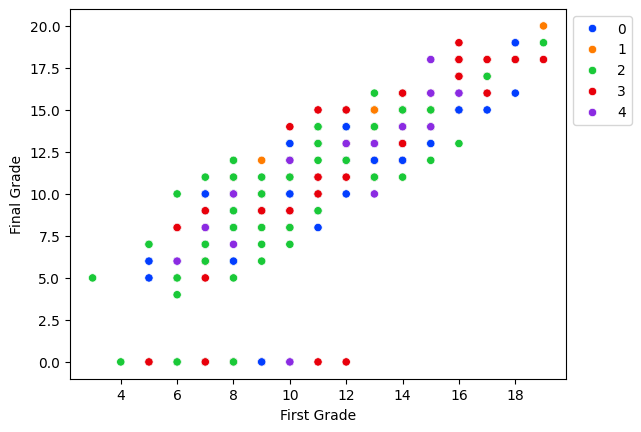

In [24]:
# mothers job;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Final Grade', hue_ = "Mother's Job", df = df_maths)

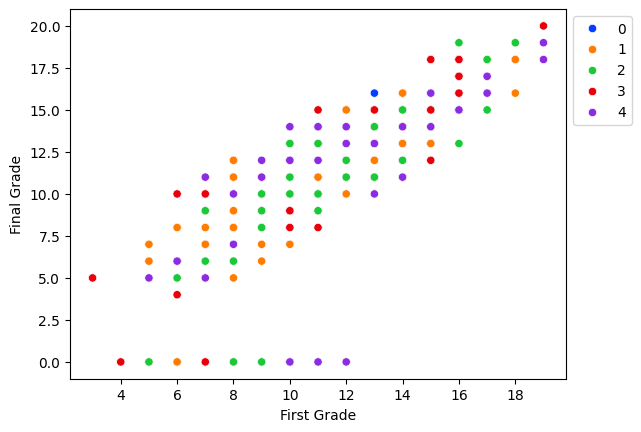

In [25]:
# fathers education;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Final Grade', hue_ = "Father's Ed", df = df_maths)

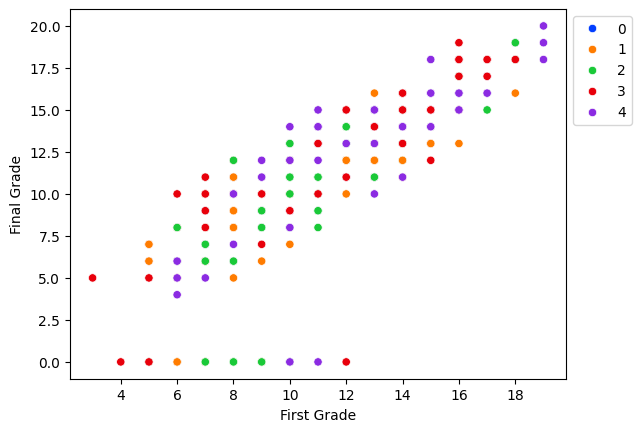

In [26]:
# mothers education;

SCATTERPLOT(x_ = 'First Grade', y_ = 'Final Grade', hue_ = "Mother's Ed", df = df_maths)

<Axes: >

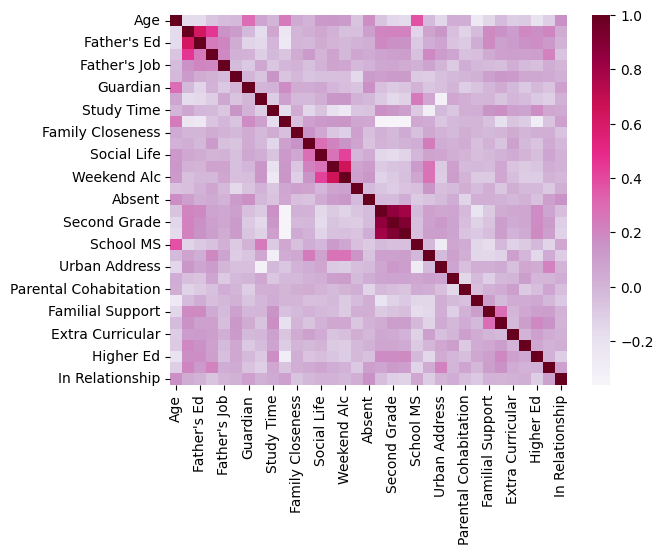

In [27]:
# generate a visual correlation matrix with a seaborn heatmap;

sns.heatmap(df_maths_corrmatrix,
            cmap = 'PuRd')

# at first glance, it is quite difficult to determine which factors heavily influence a students academic performance, as such the use of machine learning models can be quite valuable in this context.

## I want to understand two things from this dataset...

### 1) which factors have the biggest impact on a student's academic performance ? {regression problem}

### 2) how can we predict whether a student will pass or fail their final exam ? {classification problem}

## Scaling the Data...

In [28]:
# I will first need to create two different target variables for each model,
# a continuous target for the regressive random forests model, and a discrete
# target for the support vector classifier model;

features = df_maths.drop(columns = ['Final Grade'])

# final grade is sliced from the dataset and assigned to {r_target}

r_target = df_maths.iloc[:, 19:20]

# final grade is converted to a binary value, if the grade is below the
# given threshold (10): grade == 0 (fail), else if the grade is above the given 
# threshold: grade == 1 (pass)

c_target = df_maths['Final Grade'].apply(lambda x: 1 if x >= 10 else 0)

In [29]:
c_target

0      0
1      0
2      1
3      1
4      1
      ..
390    0
391    1
392    0
393    1
394    0
Name: Final Grade, Length: 395, dtype: int64

In [30]:
r_target

,Final Grade
0,6
1,6
2,10
3,15
4,10
...,...
390,9
391,16
392,7
393,10


# dataset splits

## the dataset will be split 3 times, 

### 75/25 train/test
### 85/15 train/test
### 90/10 train/test

In [31]:
# regression train/test/split;

rfeatures_train_75, rfeatures_test_25, rtarget_train_75, rtarget_test_25 = train_test_split(features, 
                                                                           r_target, 
                                                                           random_state = 42,  
                                                                           test_size = 0.25) 

# classification train/test/split;

cfeatures_train_75, cfeatures_test_25, ctarget_train_75, ctarget_test_25 = train_test_split(features, 
                                                                           c_target, 
                                                                           random_state = 42,  
                                                                           test_size = 0.25) 

# {StandardScaler()} is instantiated to {scaler};

scaler = StandardScaler()

# train/test sets for both the classification and regressive models are scaled;

rtrain_features_scaled_75 = scaler.fit_transform(rfeatures_train_75)
rtest_features_scaled_25 = scaler.transform(rfeatures_test_25)
rtrain_target_scaled_75 = scaler.fit_transform(rtarget_train_75)
rtest_target_scaled_25 = scaler.transform(rtarget_test_25)

ctrain_features_scaled_75 = scaler.fit_transform(cfeatures_train_75)
ctest_features_scaled_25 = scaler.transform(cfeatures_test_25)

# Principal Component Analysis...

In [32]:
# dimensionality reduction train/test sets are also created
# for both the regression and classification sets;

pca = PCA()
pca.n_components = 20
rtrain_features_pca_75 = pca.fit_transform(rtrain_features_scaled_75)
rtest_features_pca_25 = pca.transform(rtest_features_scaled_25)

ctrain_features_pca_75 = pca.fit_transform(ctrain_features_scaled_75)
ctest_features_pca_25 = pca.transform(ctest_features_scaled_25)

### ML TRAINING (TRAIN, TEST, SPLIT):

# Random Forest...

### without scaling;

In [33]:
RandomForest = RandomForestRegressor(n_estimators = 15, random_state = 42)

beginning = time.time()
RandomForest.fit(rfeatures_train_75, rtarget_train_75)
target_prediction_RF = RandomForest.predict(rfeatures_test_25)
end = time.time() - beginning


print(f'Performance Score: {RandomForest.score(rfeatures_test_25, rtarget_test_25)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.8716775467904373
computation time in seconds: 0.07759761810302734


### with scaling;

In [34]:
# as we can see from the R2 performance result, the scaled
# random forest training resulted in the most optimal model performance
# within the 75/25 split set, both in terms of computational
# efficiency and accuracy;

beginning = time.time()
RandomForest.fit(rtrain_features_scaled_75, rtarget_train_75)
target_prediction_RF = RandomForest.predict(rtest_features_scaled_25)
end = time.time() - beginning

print(f'Performance Score: {RandomForest.score(rtest_features_scaled_25, rtarget_test_25)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.8721491270804362
computation time in seconds: 0.10624885559082031


### with dimensionality reduction;

In [35]:
beginning = time.time()
RandomForest.fit(rtrain_features_pca_75, rtarget_train_75)
target_prediction_RF = RandomForest.predict(rtest_features_pca_25)
end = time.time() - beginning

print(f'Performance Score: {RandomForest.score(pca.transform(rtest_features_scaled_25), rtarget_test_25)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.6253723305313694
computation time in seconds: 0.09518980979919434


# Support Vector Machine...

### without scaling;

In [36]:
# the support vector model training instance
# that leveraged unscaled data provided optimal results
# in terms of computation speed and accuracy within
# the 75/25 split set;

SupportVector = SVC(kernel = 'linear')

beginning = time.time()
SupportVector.fit(cfeatures_train_75, ctarget_train_75)
target_prediction_SV = SupportVector.predict(cfeatures_test_25)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(cfeatures_test_25, ctarget_test_25)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.9292929292929293
computation time in seconds: 0.027628421783447266


### with scaling;

In [37]:
beginning = time.time()
SupportVector.fit(ctrain_features_scaled_75, ctarget_train_75)
target_prediction_SV = SupportVector.predict(ctest_features_scaled_25)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(ctest_features_scaled_25, ctarget_test_25)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.9292929292929293
computation time in seconds: 0.014528512954711914


### with dimensionality reduction;

In [38]:
beginning = time.time()
SupportVector.fit(ctrain_features_pca_75, ctarget_train_75)
target_prediction_SV = SupportVector.predict(ctest_features_pca_25)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(pca.transform(ctest_features_scaled_25), ctarget_test_25)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.898989898989899
computation time in seconds: 0.021671772003173828


## the same scaling and dimensionality reduction processes are repeated 
## for the 85/15 split set...

In [39]:
rfeatures_train_85, rfeatures_test_15, rtarget_train_85, rtarget_test_15 = train_test_split(features, 
                                                                                            r_target, 
                                                                                            random_state = 42,  
                                                                                            test_size = 0.15) 

cfeatures_train_85, cfeatures_test_15, ctarget_train_85, ctarget_test_15 = train_test_split(features, 
                                                                                            c_target, 
                                                                                            random_state = 42,  
                                                                                            test_size = 0.15)

rtrain_features_scaled_85 = scaler.fit_transform(rfeatures_train_85)
rtest_features_scaled_15 = scaler.transform(rfeatures_test_15)
rtrain_target_scaled_85 = scaler.fit_transform(rtarget_train_85)
rtest_target_scaled_15 = scaler.transform(rtarget_test_15)

ctrain_features_scaled_85 = scaler.fit_transform(cfeatures_train_85)
ctest_features_scaled_15 = scaler.transform(cfeatures_test_15)

In [40]:
pca = PCA()
pca.n_components = 20
rtrain_features_pca_85 = pca.fit_transform(rtrain_features_scaled_85)
rtest_features_pca_15 = pca.transform(rtest_features_scaled_15)

ctrain_features_pca_85 = pca.fit_transform(ctrain_features_scaled_85)
ctest_features_pca_15 = pca.transform(ctest_features_scaled_15)

# Random Forest...

### without scaling;

In [41]:
RandomForest = RandomForestRegressor(n_estimators = 15, random_state = 42)

beginning = time.time()
RandomForest.fit(rfeatures_train_85, rtarget_train_85)
target_prediction_RF = RandomForest.predict(rfeatures_test_15)
end = time.time() - beginning


print(f'Performance Score: {RandomForest.score(rfeatures_test_15, rtarget_test_15)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.7703230993417416
computation time in seconds: 0.09122276306152344


### with scaling;

In [42]:
beginning = time.time()
RandomForest.fit(rtrain_features_scaled_85, rtarget_train_85)
target_prediction_RF = RandomForest.predict(rtest_features_scaled_15)
end = time.time() - beginning

print(f'Performance Score: {RandomForest.score(rtest_features_scaled_15, rtarget_test_15)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.767606317940472
computation time in seconds: 0.09857892990112305


### with dimensionality reduction;

In [43]:
beginning = time.time()
RandomForest.fit(rtrain_features_pca_85, rtarget_train_85)
target_prediction_RF = RandomForest.predict(rtest_features_pca_15)
end = time.time() - beginning

print(f'Performance Score: {RandomForest.score(pca.transform(rtest_features_scaled_15), rtarget_test_15)}')
print(f'computation time in seconds: {end}')

# each training instance produced suboptimal results in comparison to
# the 75/25 split set

Performance Score: 0.6445873741688022
computation time in seconds: 0.20385193824768066


# Support Vector Machine...

### without scaling;

In [44]:
SupportVector = SVC(kernel = 'linear')

beginning = time.time()
SupportVector.fit(cfeatures_train_85, ctarget_train_85)
target_prediction_SV = SupportVector.predict(cfeatures_test_15)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(cfeatures_test_15, ctarget_test_15)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.95
computation time in seconds: 0.021568775177001953


### with scaling;

In [45]:
beginning = time.time()
SupportVector.fit(ctrain_features_scaled_85, ctarget_train_85)
target_prediction_SV = SupportVector.predict(ctest_features_scaled_15)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(ctest_features_scaled_15, ctarget_test_15)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.9333333333333333
computation time in seconds: 0.027558326721191406


### with dimensionality reduction;

In [46]:
# while the scaled and non-scaled training
# instances provided higher accuracy results, 
# this instance excelled in computational speed, and maintained a high 
# accuracy score. Also considering the liklihood of overfitting occuring while using
# dimensionality reduction is far lower than usual, I will deem
# this training instance as being the most optimal thus far;

beginning = time.time()
SupportVector.fit(ctrain_features_pca_85, ctarget_train_85)
target_prediction_SV = SupportVector.predict(ctest_features_pca_15)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(pca.transform(ctest_features_scaled_15), ctarget_test_15)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.9
computation time in seconds: 0.01824021339416504


# the same scaling and dimensionality reduction processes are repeated
# for the 90/10 split set...

In [47]:
rfeatures_train_90, rfeatures_test_10, rtarget_train_90, rtarget_test_10 = train_test_split(features, 
                                                                                            r_target, 
                                                                                            random_state = 42,  
                                                                                            test_size = 0.10) 

cfeatures_train_90, cfeatures_test_10, ctarget_train_90, ctarget_test_10 = train_test_split(features, 
                                                                                            c_target, 
                                                                                            random_state = 42,  
                                                                                            test_size = 0.10)

rtrain_features_scaled_90 = scaler.fit_transform(rfeatures_train_90)
rtest_features_scaled_10 = scaler.transform(rfeatures_test_10)
rtrain_target_scaled_90 = scaler.fit_transform(rtarget_train_90)
rtest_target_scaled_10 = scaler.transform(rtarget_test_10)

ctrain_features_scaled_90 = scaler.fit_transform(cfeatures_train_90)
ctest_features_scaled_10 = scaler.transform(cfeatures_test_10)

In [48]:
pca = PCA()
pca.n_components = 20
rtrain_features_pca_90 = pca.fit_transform(rtrain_features_scaled_90)
rtest_features_pca_10 = pca.transform(rtest_features_scaled_10)

ctrain_features_pca_90 = pca.fit_transform(ctrain_features_scaled_90)
ctest_features_pca_10 = pca.transform(ctest_features_scaled_10)

# Random Forest...

### without scaling;

In [49]:
RandomForest = RandomForestRegressor(n_estimators = 15, random_state = 42)

beginning = time.time()
RandomForest.fit(rfeatures_train_90, rtarget_train_90)
target_prediction_RF = RandomForest.predict(rfeatures_test_10)
end = time.time() - beginning


print(f'Performance Score: {RandomForest.score(rfeatures_test_10, rtarget_test_10)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.7419790269376461
computation time in seconds: 0.0909278392791748


### with scaling;

In [50]:
beginning = time.time()
RandomForest.fit(rtrain_features_scaled_90, rtarget_train_90)
target_prediction_RF = RandomForest.predict(rtest_features_scaled_10)
end = time.time() - beginning

print(f'Performance Score: {RandomForest.score(rtest_features_scaled_10, rtarget_test_10)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.7420240214398803
computation time in seconds: 0.12772107124328613


### with dimensionality reduction;

In [51]:
beginning = time.time()
RandomForest.fit(rtrain_features_pca_90, rtarget_train_90)
target_prediction_RF = RandomForest.predict(rtest_features_pca_10)
end = time.time() - beginning

print(f'Performance Score: {RandomForest.score(pca.transform(rtest_features_scaled_10), rtarget_test_10)}')
print(f'computation time in seconds: {end}')

# the un-scaled training instance within the 75/25 split set
# has produced the most optimal results overall.

Performance Score: 0.5401336899147635
computation time in seconds: 0.19412469863891602


# Support Vector Machine...

### without scaling;

In [52]:
SupportVector = SVC(kernel = 'linear')

beginning = time.time()
SupportVector.fit(cfeatures_train_90, ctarget_train_90)
target_prediction_SV = SupportVector.predict(cfeatures_test_10)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(cfeatures_test_10, ctarget_test_10)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.95
computation time in seconds: 0.05080914497375488


### with scaling;

In [53]:
beginning = time.time()
SupportVector.fit(ctrain_features_scaled_90, ctarget_train_90)
target_prediction_SV = SupportVector.predict(ctest_features_scaled_10)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(ctest_features_scaled_10, ctarget_test_10)}')
print(f'computation time in seconds: {end}')

Performance Score: 0.925
computation time in seconds: 0.013441801071166992


### with dimensionality reduction;

In [54]:
beginning = time.time()
SupportVector.fit(ctrain_features_pca_90, ctarget_train_90)
target_prediction_SV = SupportVector.predict(ctest_features_pca_10)
end = time.time() - beginning

print(f'Performance Score: {SupportVector.score(pca.transform(ctest_features_scaled_10), ctarget_test_10)}')
print(f'computation time in seconds: {end}')

# the dimensionality reduction training instance within the 85/10
# split set has produced the most reliable and optimal 
# results overall.

Performance Score: 0.85
computation time in seconds: 0.023616313934326172


# ML TESTING (K-FOLD CROSS-VALIDATION):

### SVC (Support Vector Classifier)

In [55]:
# the dataset will be split into three subgroups wherein one will be held
# out for testing purposes (k-1)

folds = 3
KFold = KFold(n_splits = folds, shuffle = True, random_state = 42)

SupportVector_cv_res = cross_val_score(SupportVector, features, c_target, cv = KFold)

# results will be presented in a multi-line string to 
# avoid excessive printing;

svm_accuracy = f'''SVM EVALUATION...

Cross-Validation Accuracy: {SupportVector_cv_res}

Mean Accuracy: {SupportVector_cv_res.mean()}'''

print(svm_accuracy)

SVM EVALUATION...

Cross-Validation Accuracy: [0.93939394 0.90909091 0.90839695]

Mean Accuracy: 0.9189605983499113


### RFR (Random Forests Regressor)

In [56]:
# the exact same process will be utilised to evaluate the RFR model;

RandomForest_cv_res = cross_val_score(RandomForest, features, r_target, cv = KFold)

rfr_accuracy = f'''RFR EVALUATION...

Cross-Validation Accuracy: {RandomForest_cv_res}

Mean Accuracy: {RandomForest_cv_res.mean()}'''

print(rfr_accuracy)

RFR EVALUATION...

Cross-Validation Accuracy: [0.84303955 0.90587298 0.79497371]

Mean Accuracy: 0.8479620829354925


# HYPERPARAMETER TUNING WITH GRIDSEARCH CV:

### RFR...

In [57]:
# grid parameters will be assigned to variable {parameter}
# using a dict datastructure;

parameter = {'n_estimators': [10, 15, 25, 50],
             'max_depth': [None, 10, 20, 30],
             'min_samples_split': [2, 5, 10, 15, 20],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'max_features': ['auto', 'sqrt', 'log2'],
             'bootstrap': [True, False]}

# {GridSearchCV} will be instantiated to variable {grid}

grid = GridSearchCV(RandomForest, 
                    parameter, 
                    refit = True, 
                    verbose = 1)

# the train optimal train features will be fitted to the 
# grid search, which will search exhaustively for the 
# most optimal parameters;

grid.fit(rtrain_features_scaled_75, rtrain_target_scaled_75)

# results will then be printed out to the script;

res_rf = f'''{grid.best_params_}

{grid.best_estimator_}'''

print(res_rf)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=15, random_state=42)


In [58]:
# this optimal model will then be evaluated on its
# ability to predict important features;

predictions = grid.predict(rtest_features_scaled_25)

# evaluation metrics for the RFR model will be Mean Absolute Error;

mae = mean_absolute_error(rtest_target_scaled_25, predictions)

# and r squared;

r2 = r2_score(rtest_target_scaled_25, predictions)

# these will then be printed and displayed within the script;

r2_mae = f'''MEAN ABSOLUTE ERROR: {mae}

R2: {r2}'''

print(r2_mae)

MEAN ABSOLUTE ERROR: 0.3065022867825619

R2: 0.8121703887258059


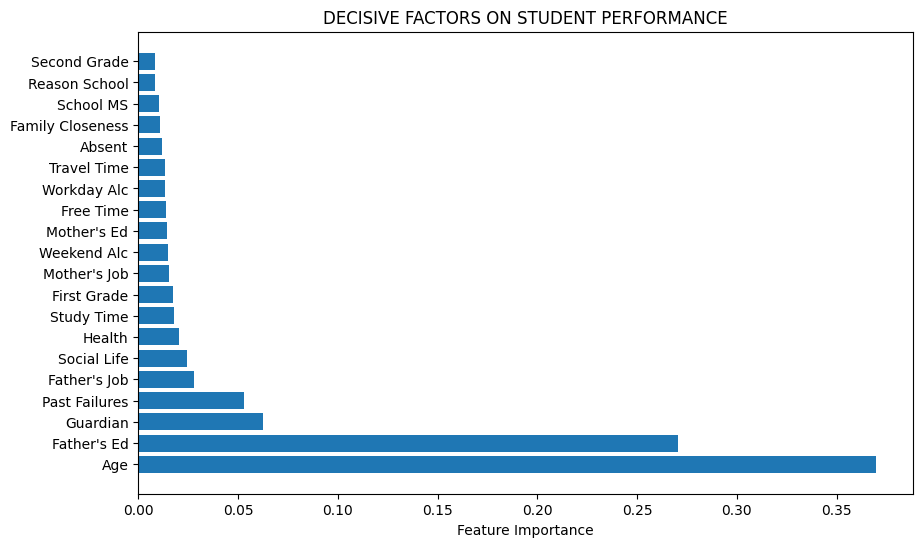

In [59]:
# important features will then be displayed on a graph for 
# ease of interpretation;

# as we can see two features stand out, Age and Father's education
# appear to have a huge impact on a students academic performance.

DISPLAY_IMPORTANCE(model = RandomForest,
                   df_features = features,
                   train_features = rtrain_features_scaled_75,
                   title = 'DECISIVE FACTORS ON STUDENT PERFORMANCE',
                   alignment = 'center',
                   label = 'Feature Importance')

### SVM...

In [60]:
# parameters will be set for the grid search;

parameter = {'C': [0.01, 0.1, 1, 10, 100, 1000],
             'kernel': ['linear']}

# {GridSearchCV()} will be instantiated to {grid} with these new
# SVM parameters;

grid = GridSearchCV(SupportVector, 
                    parameter, 
                    refit = True,
                    verbose = 1)

# optimal train/test sets as discovered during the 
# train/test/split phase will be fitted to the grid;

grid.fit(ctrain_features_pca_85, ctarget_train_85)

# and the optimal parameters discovered will be printed and displayed;

print(grid.best_params_)
print()
print(grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'C': 1, 'kernel': 'linear'}

SVC(C=1, kernel='linear')


In [61]:
# predictions made by the tuned model will be processed and displayed;

predictions = grid.predict(ctest_features_pca_15)

predictions

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1])

In [62]:
# a classification report and confusion matrix will be used to 
# evaluate the performance of the SVC;

print(classification_report(ctarget_test_15, predictions))

# as we can see the model is capable of predicting whether a student
# will pass or fail their final exam with a high degree of accuracy.
# the results do not indicate that our model is over- or underfit;

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.91      0.95      0.93        41

    accuracy                           0.90        60
   macro avg       0.89      0.87      0.88        60
weighted avg       0.90      0.90      0.90        60



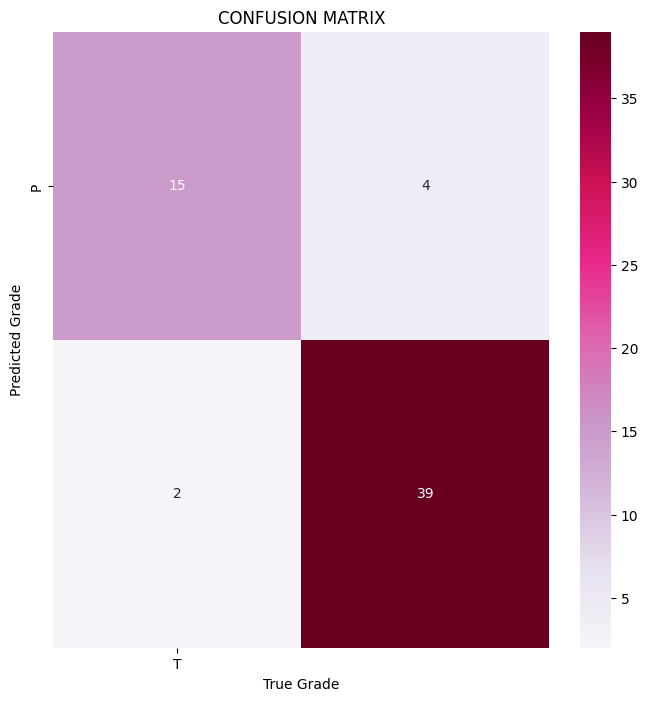

In [63]:
# a confusion matrix will be generated to display model performance
# in an easily digested manner;

CONFUSION_MATRIX(target = ctarget_test_15, 
                 prediction = predictions,
                 label_x = 'True Grade',
                 label_y = 'Predicted Grade')